In [17]:
## Importing all the package needed to run teh watershed workflow

import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging
import copy

In [18]:
import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.densification
import watershed_workflow.condition
watershed_workflow.ui.setup_logging(1,None)
crs=None

# RiverTree

<b> tree data structures, built on watershed_workflow.tinytree </b>

### Construction

Reaches are collection of `LineString` objects with coordnates ordere upstream to downstream

In [19]:
reach1 = shapely.geometry.LineString([(4, 10), (4.01, 5.0), (4, 0)])
reach2 = shapely.geometry.LineString([(1, 19), (2, 15.01), (4, 10)])
reach3 = shapely.geometry.LineString([(8, 19), (6, 15.01), (4, 10)])
reaches = [reach1, reach2, reach3]

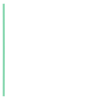

In [20]:
reach1 # change to reach2 and reach3

Rivers are constructed using collection of reaches using one of the two methods:

1) `geometry` looks at coincident coordinates
2) `hydroseq` valid only for NHDPlus data, this uses the  NHDPlus VAA tables Hydrologic Sequence. If using this method, get_reaches() must have been called with both
  'HydrologicSequence' and 'DownstreamMainPathHydroSeq' properties requested (or properties=True).

In [21]:
rivers = watershed_workflow.construct_rivers(reaches=reaches, method='geometry')

2023-12-06 16:51:15,021 - root - INFO: 
2023-12-06 16:51:15,021 - root - INFO: Constructing river network
2023-12-06 16:51:15,021 - root - INFO: ------------------------------
2023-12-06 16:51:15,022 - root - INFO: Generating the river tree
2023-12-06 16:51:15,023 - root - INFO:  ... generated 1 rivers


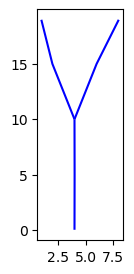

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
watershed_workflow.plot.rivers(rivers, ax=ax, crs=None, color='b')
ax.set_aspect('equal', adjustable='box')


### Traversing Tree Structure

`RiverTree` is a composed of nodes. A single node in the River is also a `RiverTree` object, representing one reach and its upstream children.

We can access individial nodes and its "relatives"

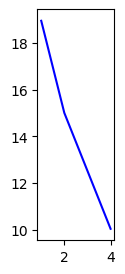

In [23]:
river = rivers[0]
# acess individial node
node  = list(river.preOrder())[1]  ##### CHANGE TO 0 and 2 #####

fig, ax = plt.subplots(1, 1, figsize=(3,3))
watershed_workflow.plot.river(node, ax=ax, crs=None, color='b')
ax.set_aspect('equal', adjustable='box')

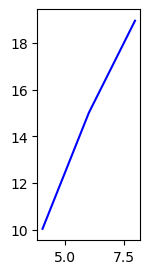

In [24]:
siblings = list(node.siblings()); print(siblings)

fig, ax = plt.subplots(1, 1, figsize=(3,3))
watershed_workflow.plot.river(siblings[0], ax=ax, crs=None, color='b')
ax.set_aspect('equal', adjustable='box')

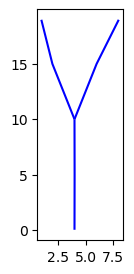

In [25]:
parent = node.parent

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
watershed_workflow.plot.river(parent, ax=ax, crs=None, color='b')
ax.set_aspect('equal', adjustable='box')

In [26]:
list(parent.children)

### Node and Segment

While single node which is a `RiverTree` object represent one reach and its upstream children, node.segment gives the `LineString` for this one reach only

<class 'watershed_workflow.river_tree.River'>
<class 'shapely.geometry.linestring.LineString'>


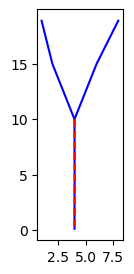

In [27]:
## Let's plot node and its reach segment for first node of the river tree
node = list(river.preOrder())[0]; print(type(node))

reach_seg = node.segment; print(type(reach_seg))


fig, ax = plt.subplots(1, 1, figsize=(3, 3))
watershed_workflow.plot.river(node, ax=ax, crs=None, color='b') 
watershed_workflow.plot.shply(reach_seg , ax=ax, crs=None, color='r', linestyle='--')
ax.set_aspect('equal', adjustable='box')


### Editing River Tree

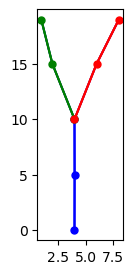

In [28]:
## Plotting three reach segments of the river tree
river = rivers[0]
colors = ['b', 'g', 'r']

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

for i, node in enumerate(river.preOrder()):
    watershed_workflow.plot.rivers(node, ax=ax, crs=None, color=colors[i])
    x,y=node.segment.xy 
    ax.plot(x,y,'-o',markersize=5, color=colors[i])
ax.set_aspect('equal', adjustable='box')

Let's try to make green reach shorter

In [29]:
# access node for reach to be edited 
node  = list(river.preOrder())[1]

# acess LineString for the reach
seg = node.segment; print(type(seg))

<class 'shapely.geometry.linestring.LineString'>


In [30]:
## change the LineString

# get coordinates
seg_coords = seg.coords[:]; print(seg_coords)

# update coordinates
seg_coords_new = seg_coords[1:]; print(seg_coords_new)

# create new LineString
seg_new = shapely.geometry.LineString(seg_coords_new)

# update the reach segment in the RiverTree
node.segment = seg_new

[(1.0, 19.0), (2.0, 15.01), (4.0, 10.0)]
[(2.0, 15.01), (4.0, 10.0)]


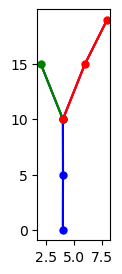

In [31]:
# plot the updated river tree
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

for i, node in enumerate(river.preOrder()):
    watershed_workflow.plot.rivers(node, ax=ax, crs=None, color=colors[i])
    x,y=node.segment.xy 
    ax.plot(x,y,'-o',markersize=5, color=colors[i])
ax.set_aspect('equal', adjustable='box')

# SplitHucs 

<b> Class for dealing with the multiple interacting views of HUCs </b>

In [32]:
# edges of huc boundary
edge1 = [[x, 0] for x in np.arange(0, 20, 4)]
edge2 = [[16, y] for y in np.arange(4, 24, 4)]
edge3 = [[x, 20] for x in np.arange(12, -4, -4)]
edge4 = [[0, y] for y in np.arange(16, 0, -4)]

In [33]:
seg1 = shapely.geometry.LineString([[16, 4], [16, 8], [16, 12], [16, 16], [16, 20], [12, 20], [8, 20], [4, 20], [0, 20], [0, 16], [0, 12], [0, 8], [0, 4], [0, 0], [4, 0]])
seg2 = shapely.geometry.LineString([[4,0],[8, 0], [12, 0], [16, 0],[16, 4]])

In [34]:
ws = shapely.geometry.Polygon(seg1.coords[:]+seg2.coords[:])
watershed = watershed_workflow.split_hucs.SplitHUCs([ws])

2023-12-06 16:51:15,370 - root - INFO: Removing holes on 1 polygons
2023-12-06 16:51:15,371 - root - INFO:   -- removed interior
2023-12-06 16:51:15,371 - root - INFO:   -- union
2023-12-06 16:51:15,372 - root - INFO: Parsing 1 components for holes
2023-12-06 16:51:15,372 - root - INFO:   -- complete


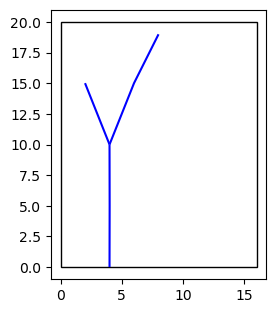

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
watershed_workflow.plot.rivers(rivers, ax=ax, crs=None, color='b')
watershed_workflow.plot.hucs(watershed, ax=ax, crs=None, color='k')
ax.set_aspect('equal', adjustable='box')

### HUC Segments

In [36]:
list(watershed.segments)